In [184]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brist1d/sample_submission.csv
/kaggle/input/brist1d/activities.txt
/kaggle/input/brist1d/train.csv
/kaggle/input/brist1d/test.csv


# FEATURE ENGINEERING THOUGHTS 

- Features already present:
    - bg (lag)
    - total insulin (lag agg)
    - total carbs (lag agg)
    - mean hr (lag agg)
    - total steps (lag agg)
    - total cals (lag agg)
    - activity (lag)
 
- Features created so far:
    - DATE (day, hour, minute)

- Features that could be created:
    - since we can't rely on user id (some new user id will be in the test set), we should extract agg features across the user ids, since those aggs can be replicated on the hidden test set.
    - what's the mean glucose for this user? (rolling window)
    - what are additional lags for glucose (lag)
    - recent delta in glucose (diff) 

In [185]:
train_df = pd.read_csv('/kaggle/input/brist1d/train.csv',low_memory=False)
test_df = pd.read_csv('/kaggle/input/brist1d/test.csv')
activities_df = pd.read_csv('/kaggle/input/brist1d/activities.txt')
sample_submission_df = pd.read_csv('/kaggle/input/brist1d/sample_submission.csv')

# EDA 

In [186]:
print('train shape: ', train_df.shape)
print('test shape: ', test_df.shape)
print('activities shape: ', activities_df.shape)
print('sample_submission shape: ', sample_submission_df.shape)

train shape:  (177024, 508)
test shape:  (3644, 507)
activities shape:  (21, 1)
sample_submission shape:  (3644, 2)


In [187]:
train_df.head(-4)

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177015,p12_25290,p12,23:15:00,7.7,7.9,8.4,8.7,8.8,9.1,9.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.6
177016,p12_25291,p12,23:20:00,7.9,8.4,8.7,8.8,9.1,9.2,9.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5
177017,p12_25292,p12,23:25:00,8.4,8.7,8.8,9.1,9.2,9.4,9.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.4
177018,p12_25293,p12,23:30:00,8.7,8.8,9.1,9.2,9.4,9.8,10.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.3


In [188]:
train_df['activity-0:40'].unique()

array([nan, 'Walk', 'Indoor climbing', 'Yoga', 'Zumba', 'HIIT', 'Dancing',
       'Swim', 'Outdoor Bike', 'Aerobic Workout', 'Sport', 'Walking',
       'Running', 'Swimming', 'Run', 'Workout', 'Tennis',
       'Strength training', 'Spinning', 'Weights', 'Hike', 'Bike'],
      dtype=object)

# Feature Engineering 

In [189]:
def create_features(df):
    df['time'] = pd.to_datetime(df['time'],format='%H:%M:%S')
    df['hour'] = df['time'].dt.hour 
    df['minute'] = df['time'].dt.minute
    df.drop('time',axis=1,inplace=True)
    # df.drop('p_num',axis=1,inplace=True)
    return df 

In [190]:
train_features = create_features(train_df)
test_features = create_features(test_df)

In [191]:
# def to_categorical(df):
#     for col in df.columns:
#         if df[col].dtype == 'object':
#             df[col] = df[col].astype('category')
    
#     return df 

In [192]:
# train_features = to_categorical(train_df)
# test_features = to_categorical(test_df)

### Categorical Missing Values 

In [193]:
data = {'activity': ['Indoor climbing','Run','Strength training','Swim','Bike','Dancing','Stairclimber','Spinning','Walking','HIIT','Outdoor Bike','Walk','Aerobic Workout','Tennis','Workout','Hike','Zumba','Sport','Yoga','Swimming','Weights','Running']}
df = pd.DataFrame(data)

# create a dictionary mapping to numerical values 
activity_mapping = {activity: i+1 for i, activity in enumerate(df['activity'])}
activity_mapping


{'Indoor climbing': 1,
 'Run': 2,
 'Strength training': 3,
 'Swim': 4,
 'Bike': 5,
 'Dancing': 6,
 'Stairclimber': 7,
 'Spinning': 8,
 'Walking': 9,
 'HIIT': 10,
 'Outdoor Bike': 11,
 'Walk': 12,
 'Aerobic Workout': 13,
 'Tennis': 14,
 'Workout': 15,
 'Hike': 16,
 'Zumba': 17,
 'Sport': 18,
 'Yoga': 19,
 'Swimming': 20,
 'Weights': 21,
 'Running': 22}

In [194]:
activity_mapping.get('running',-1)

-1

In [195]:
# map each activity to a numeric value 
activity_columns = [col for col in train_features.columns if col.startswith('activity-')]

# create a dictionary mapping to numerical value 
for col in activity_columns:

    train_features[col] = train_features[col].apply(lambda x: activity_mapping.get(x,-1))
    test_features[col] = test_features[col].apply(lambda x: activity_mapping.get(x,-1))

train_features[activity_columns].head()


,activity-5:55,activity-5:50,activity-5:45,activity-5:40,activity-5:35,activity-5:30,activity-5:25,activity-5:20,activity-5:15,activity-5:10,...,activity-0:45,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


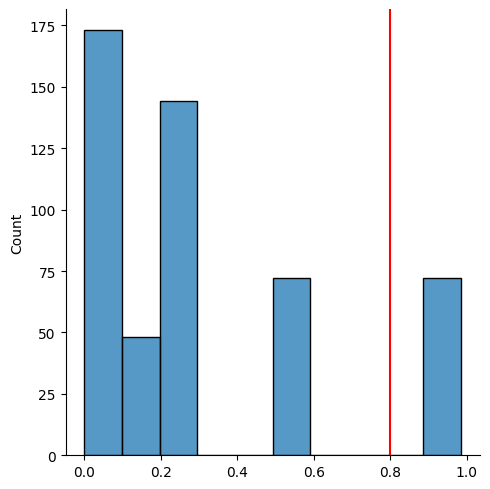

In [196]:
#### distribution of null percentage
sns.displot(train_features.isnull().sum() / train_features.shape[0])
plt.axvline(0.8,0,1.7,color='red')

#### Drop Features with >98% Null Values 

In [197]:
def drop_null_features(df):
    
    for col in df.columns:
        
        if df[col].isnull().sum() / df[col].shape[0] >= 0.8:
            
            df.drop(col,axis=1,inplace=True)
    return df 

In [198]:
train_features = drop_null_features(train_features)
test_features = drop_null_features(test_features)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


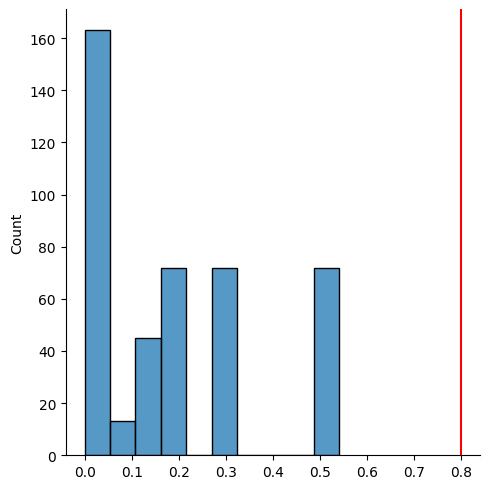

In [199]:
sns.displot(train_features.isnull().sum() / train_features.shape[0])
plt.axvline(0.8,0,1.7,color='red')

In [200]:
train_features.shape

(177024, 437)

### Missing Values 

In [201]:

def fill_missing_bg_values(df):

    bg_columns = [col for col in df.columns if col.startswith('bg-')]
    df[bg_columns] = df[bg_columns].copy().ffill(axis=1).bfill(axis=1)
    return df 

def fill_missing_insulin_values(df):
    insulin_columns = [col for col in df.columns if col.startswith('insulin-')]
    df[insulin_columns] = df[insulin_columns].copy().ffill(axis=1).bfill(axis=1)
    return df

def fill_missing_carbs_values(df):
    carbs_columns = [col for col in df.columns if col.startswith('carbs-')]
    df[carbs_columns] = df[carbs_columns].copy().ffill(axis=1).bfill(axis=1)
    return df 

def fill_missing_hr_values(df):
    hr_columns = [col for col in df.columns if col.startswith('hr-')]
    df[hr_columns] = df[hr_columns].copy().ffill(axis=1).bfill(axis=1)
    return df 

def fill_missing_steps_values(df):
    steps_columns = [col for col in df.columns if col.startswith('steps-')]
    df[steps_columns] = df[steps_columns].copy().ffill(axis=1).bfill(axis=1)
    return df 

def fill_missing_cals_values(df):
    cals_columns = [col for col in df.columns if col.startswith('cals-')]
    df[cals_columns] = df[cals_columns].copy().ffill(axis=1).bfill(axis=1)
    return df 

def fill_missing_values(df):
    df = fill_missing_bg_values(df)
    df = fill_missing_insulin_values(df)
    df = fill_missing_carbs_values(df)
    df = fill_missing_hr_values(df)
    df = fill_missing_steps_values(df)
    df = fill_missing_cals_values(df)
    return df 

In [202]:
train_features = fill_missing_values(train_features)

In [203]:
test_features = fill_missing_values(test_features)

### Participant Features 

In [204]:
train_features.columns.to_list()

['id',
 'p_num',
 'bg-5:55',
 'bg-5:50',
 'bg-5:45',
 'bg-5:40',
 'bg-5:35',
 'bg-5:30',
 'bg-5:25',
 'bg-5:20',
 'bg-5:15',
 'bg-5:10',
 'bg-5:05',
 'bg-5:00',
 'bg-4:55',
 'bg-4:50',
 'bg-4:45',
 'bg-4:40',
 'bg-4:35',
 'bg-4:30',
 'bg-4:25',
 'bg-4:20',
 'bg-4:15',
 'bg-4:10',
 'bg-4:05',
 'bg-4:00',
 'bg-3:55',
 'bg-3:50',
 'bg-3:45',
 'bg-3:40',
 'bg-3:35',
 'bg-3:30',
 'bg-3:25',
 'bg-3:20',
 'bg-3:15',
 'bg-3:10',
 'bg-3:05',
 'bg-3:00',
 'bg-2:55',
 'bg-2:50',
 'bg-2:45',
 'bg-2:40',
 'bg-2:35',
 'bg-2:30',
 'bg-2:25',
 'bg-2:20',
 'bg-2:15',
 'bg-2:10',
 'bg-2:05',
 'bg-2:00',
 'bg-1:55',
 'bg-1:50',
 'bg-1:45',
 'bg-1:40',
 'bg-1:35',
 'bg-1:30',
 'bg-1:25',
 'bg-1:20',
 'bg-1:15',
 'bg-1:10',
 'bg-1:05',
 'bg-1:00',
 'bg-0:55',
 'bg-0:50',
 'bg-0:45',
 'bg-0:40',
 'bg-0:35',
 'bg-0:30',
 'bg-0:25',
 'bg-0:20',
 'bg-0:15',
 'bg-0:10',
 'bg-0:05',
 'bg-0:00',
 'insulin-5:55',
 'insulin-5:50',
 'insulin-5:45',
 'insulin-5:40',
 'insulin-5:35',
 'insulin-5:30',
 'insulin-5:25',


In [205]:
train_features.groupby(['p_num'])['bg-0:00'].mean()

p_num
p01    8.902400
p02    9.332750
p03    8.583733
p04    7.759605
p05    8.139792
p06    8.939234
p10    6.370370
p11    9.376481
p12    7.853105
Name: bg-0:00, dtype: float64

In [206]:
def add_participant_features(df):
    
    df['bg-0:00-mean'] = df.copy().groupby(['p_num'])['bg-0:00'].transform('mean')
    df['bg-0:00-std'] = df.copy().groupby(['p_num'])['bg-0:00'].transform('std')
    df['bg-0:00-max'] = df.copy().groupby(['p_num'])['bg-0:00'].transform('max')

    df['insulin-0:00-mean'] = df.copy().groupby(['p_num'])['insulin-0:00'].transform('mean')
    df['insulin-0:00-std'] = df.copy().groupby(['p_num'])['insulin-0:00'].transform('std')
    df['insulin-0:00-max'] = df.copy().groupby(['p_num'])['insulin-0:00'].transform('max')

    df['steps-0:00-mean'] = df.copy().groupby(['p_num'])['steps-0:00'].transform('mean')
    df['steps-0:00-std'] = df.copy().groupby(['p_num'])['steps-0:00'].transform('std')
    df['steps-0:00-max'] = df.copy().groupby(['p_num'])['steps-0:00'].transform('max')

    df['cals-0:00-mean'] = df.copy().groupby(['p_num'])['cals-0:00'].transform('mean')
    df['cals-0:00-std'] = df.copy().groupby(['p_num'])['cals-0:00'].transform('std')
    df['cals-0:00-max'] = df.copy().groupby(['p_num'])['cals-0:00'].transform('max')

    return df 
    

In [207]:
train_features = add_participant_features(train_features)
test_features = add_participant_features(test_features)

/tmp/ipykernel_66/3313149276.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bg-0:00-mean'] = df.copy().groupby(['p_num'])['bg-0:00'].transform('mean')
/tmp/ipykernel_66/3313149276.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bg-0:00-std'] = df.copy().groupby(['p_num'])['bg-0:00'].transform('std')
/tmp/ipykernel_66/3313149276.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

### Add Rolling Features 

###  Drop id columns 

In [208]:
train_features = train_features.copy().drop('id',axis=1).drop('p_num',axis=1)
test_features = test_features.copy().drop('p_num',axis=1)

# Cross Validation

In [209]:
x = train_features.copy().drop('bg+1:00',axis=1)
x.head()

,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,...,bg-0:00-max,insulin-0:00-mean,insulin-0:00-std,insulin-0:00-max,steps-0:00-mean,steps-0:00-std,steps-0:00-max,cals-0:00-mean,cals-0:00-std,cals-0:00-max
0,9.6,9.6,9.6,9.6,9.6,9.7,9.7,9.7,9.2,9.2,...,27.8,0.130766,0.695182,11.7417,56.268156,115.715309,741.0,9.029529,6.572246,53.0
1,9.7,9.7,9.7,9.7,9.7,9.2,9.2,9.2,8.7,8.7,...,27.8,0.130766,0.695182,11.7417,56.268156,115.715309,741.0,9.029529,6.572246,53.0
2,9.2,9.2,9.2,9.2,9.2,8.7,8.7,8.7,8.4,8.4,...,27.8,0.130766,0.695182,11.7417,56.268156,115.715309,741.0,9.029529,6.572246,53.0
3,8.7,8.7,8.7,8.7,8.7,8.4,8.4,8.4,8.1,8.1,...,27.8,0.130766,0.695182,11.7417,56.268156,115.715309,741.0,9.029529,6.572246,53.0
4,8.4,8.4,8.4,8.4,8.4,8.1,8.1,8.1,8.3,8.3,...,27.8,0.130766,0.695182,11.7417,56.268156,115.715309,741.0,9.029529,6.572246,53.0


In [210]:
y = train_features.copy()['bg+1:00']
y.head()

0    13.4
1    12.8
2    15.5
3    14.8
4    12.7
Name: bg+1:00, dtype: float64

In [211]:
def rmse(y_hat, y):
    '''root mean squared error calculation'''

    return np.sqrt(np.sum((y_hat - y)**2)/len(y_hat))

# create kfold object 
kf = KFold(n_splits=5)

# get the indicies for each split 
metric_list = []
boosting_rounds = []
for i, (train, test) in enumerate(kf.split(x)):

    print(f'Fold {i}')

    print('\t train: ', train.shape)
    print('\t test: ', test.shape)

    # create train/test set using indexing 
    x_train, x_test, y_train, y_test = x.iloc[train], x.iloc[test], y[train], y[test]

    # train the model 
    reg = xgb.XGBRegressor(n_estimators=1000,early_stopping_rounds=50, enable_categorical=True)
    reg.fit(x_train, y_train,
           eval_set=[(x_train, y_train),(x_test, y_test)],verbose=False)

    # predict on test set 
    y_hat = reg.predict(x_test)

    # calculate current fold metric 
    metric_current_fold = rmse(y_hat, y_test)
    print('\t rmse: ', metric_current_fold)
    metric_list.append(metric_current_fold)
    

    # calculate the fold boosting rounds used 
    boosting_rounds_current_fold = reg.get_booster().best_iteration
    boosting_rounds.append(boosting_rounds_current_fold)
    print('\t boosting rounds: ', boosting_rounds_current_fold)

# average the metric across all folds 
metric_avg = np.mean(metric_list) 
print('average rmse: ', metric_avg)
boosting_rounds_avg = np.mean(boosting_rounds)
print('avg boosting rounds: ', boosting_rounds_avg)

Fold 0
	 train:  (141619,)
	 test:  (35405,)
	 rmse:  2.329400326659712
	 boosting rounds:  9
Fold 1
	 train:  (141619,)
	 test:  (35405,)
	 rmse:  2.143334591959842
	 boosting rounds:  28
Fold 2
	 train:  (141619,)
	 test:  (35405,)
	 rmse:  2.029004923119525
	 boosting rounds:  24
Fold 3
	 train:  (141619,)
	 test:  (35405,)
	 rmse:  1.79904536887766
	 boosting rounds:  8
Fold 4
	 train:  (141620,)
	 test:  (35404,)
	 rmse:  1.9446193745289782
	 boosting rounds:  9
average rmse:  2.0490809170291433
avg boosting rounds:  15.6


# Retrain on all the data 


In [212]:
reg_full_data = xgb.XGBRegressor(n_estimators=33,enable_categorical=True)
reg_full_data.fit(x, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=33, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Submit Prediction

In [213]:
sample_submission_df.shape

(3644, 2)

In [214]:
sample_submission_df.head()

,id,bg+1:00
0,p01_8459,9.6
1,p01_8460,4.6
2,p01_8461,8.0
3,p01_8462,9.9
4,p01_8463,5.3


In [215]:
test_df.shape

(3644, 448)

In [216]:
test_features.shape

(3644, 447)

In [217]:
test_features.head()

,id,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,...,bg-0:00-max,insulin-0:00-mean,insulin-0:00-std,insulin-0:00-max,steps-0:00-mean,steps-0:00-std,steps-0:00-max,cals-0:00-mean,cals-0:00-std,cals-0:00-max
0,p01_8459,9.2,9.2,9.2,9.2,10.2,10.2,10.2,10.3,10.3,...,20.2,0.219686,0.930584,6.0583,38.143443,80.751307,567.0,8.395902,5.880342,42.76
1,p01_8460,9.9,9.9,9.9,9.9,9.9,9.4,9.4,9.4,9.1,...,20.2,0.219686,0.930584,6.0583,38.143443,80.751307,567.0,8.395902,5.880342,42.76
2,p01_8461,5.5,5.5,5.5,5.5,5.5,5.5,5.5,5.2,5.2,...,20.2,0.219686,0.930584,6.0583,38.143443,80.751307,567.0,8.395902,5.880342,42.76
3,p01_8462,3.4,3.4,3.4,3.4,3.9,3.9,3.9,4.7,4.7,...,20.2,0.219686,0.930584,6.0583,38.143443,80.751307,567.0,8.395902,5.880342,42.76
4,p01_8463,8.3,8.3,8.3,8.3,8.3,10.0,10.0,10.0,12.2,...,20.2,0.219686,0.930584,6.0583,38.143443,80.751307,567.0,8.395902,5.880342,42.76


In [218]:
submission = pd.DataFrame()

In [219]:
submission['id'] = test_features['id']

In [220]:
submission['bg+1:00'] = reg_full_data.predict(test_features.drop('id',axis=1))

In [221]:
submission.head()

,id,bg+1:00
0,p01_8459,9.254095
1,p01_8460,6.697371
2,p01_8461,8.063756
3,p01_8462,10.643380
4,p01_8463,6.231556


In [222]:
submission.to_csv('/kaggle/working/submission.csv',index=False)

# Feature Importance and SHAP Values 

In [235]:
feature_columns = np.array(test_features.drop('id',axis=1).columns)
feature_importances = reg_full_data.feature_importances_
feat_importance_df = pd.DataFrame({
    'feature': feature_columns,
    'importance': feature_importances
})
importance_sorted = feat_importance_df.sort_values('importance',ascending=False)
importance_sorted.head()

,feature,importance
71,bg-0:00,0.174336
443,cals-0:00-mean,0.022190
434,bg-0:00-mean,0.014422
65,bg-0:30,0.013177
68,bg-0:15,0.012682


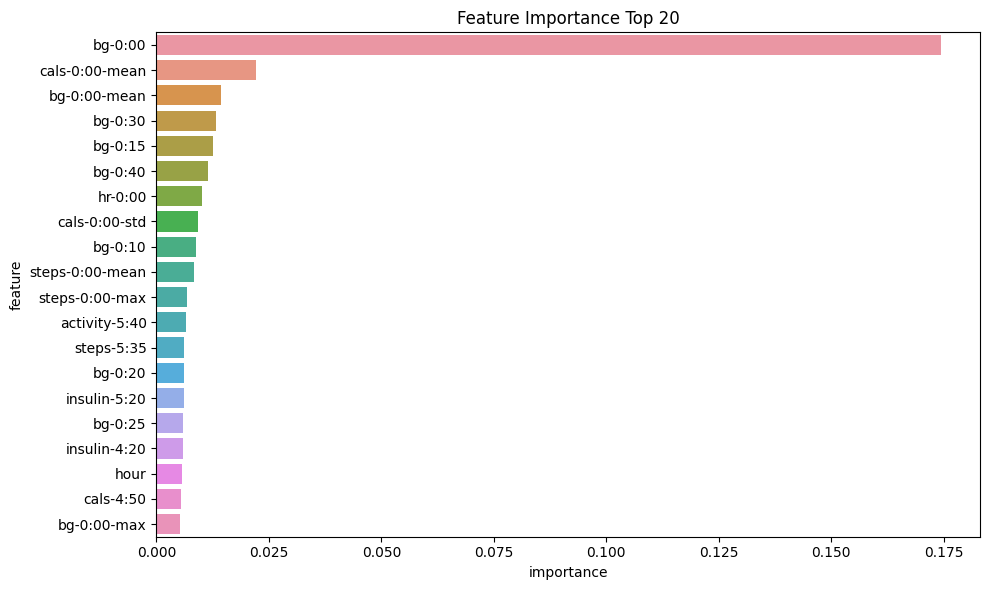

In [238]:
import matplotlib.pyplot as plt 

plt.figure(figsize=(10,6))
sns.barplot(data=importance_sorted.head(20),x='importance',y='feature')
plt.title('Feature Importance Top 20\')
plt.tight_layout()
plt.show()

According to the implicit feature importance calculated by xgboost, bg-0:00 is by far the most important feature, followed by the mean of bg-0:00, and cals-0:00. It's interesting to see that many of the features I aggregated by participant id made this top 20 list. 

### SHAP values 

In [241]:
import shap

explainer = shap.TreeExplainer(reg_full_data)
explanation = explainer(test_features.drop('id',axis=1))
shap_values = explanation.values
shap_values

array([[-0.00937836, -0.00019643,  0.02470806, ...,  0.01280041,
         0.00571581,  0.00177075],
       [ 0.00584927, -0.00121592,  0.00263387, ...,  0.11676739,
         0.03834489,  0.02027666],
       [-0.00844518, -0.00028323, -0.00226334, ...,  0.02991612,
         0.00882527, -0.02979324],
       ...,
       [ 0.00961613,  0.0086627 ,  0.00363834, ...,  0.14590603,
         0.00567675,  0.00124222],
       [-0.00033702, -0.00046923,  0.00309836, ...,  0.07683586,
         0.00451625,  0.00166011],
       [-0.00143581, -0.00040124,  0.00270172, ...,  0.17667742,
         0.00567675,  0.00261354]], dtype=float32)

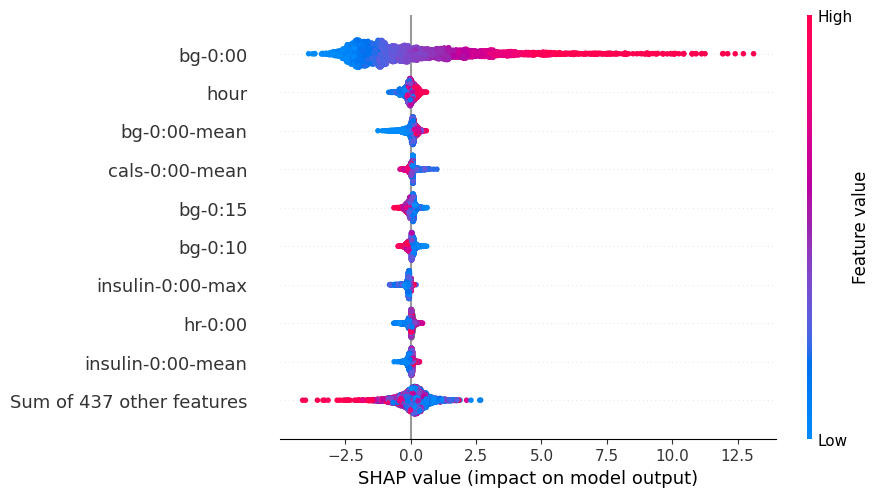

In [242]:
shap.plots.beeswarm(explanation)

SHAP value beeswarm plot also confirms that bg-0:00 was the most important feature. According to the plot, high values of bg-0:00 have a large impact on model output. But low values don't have much effect. 